In [9]:
import logging
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import pyproj
import requests

from disp_xr import download, product
from disp_xr import stack as disp_stack
from disp_xr.utils import latlon_to_utm

logger = logging.getLogger('disp_xr')

# Configure basic logging
logger.setLevel(logging.INFO)  # Set logging level

# Create handler (console output)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)  # Set level for this handler

# Add handler to logger
logger.addHandler(handler)

# Prevent duplicate logs if the root logger already has handlers
logger.propagate = False

# Download DISP

In [2]:
def _download(url: str, out_dir: Path) -> Path:
    """Download *url* into *out_dir* if needed and return the local path."""
    out_dir.mkdir(parents=True, exist_ok=True)
    dest = out_dir / Path(url).name
    print(f'Downloading: {dest}')
    if dest.exists():
        return dest

    r = requests.get(url, stream=True, timeout=60)
    r.raise_for_status()
    with open(dest, "wb") as f:
        for chunk in r.iter_content(chunk_size=2**20):
            f.write(chunk)
    return dest

In [3]:
# Setup working directory
work_dir = Path('/u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir').resolve()
nc_dir = work_dir / "ncs"

# Set up frame id, start and end date
frame_id = 44055
start_datetime = None
end_datetime = None

# Search ASF DAAC
products_df = download.search(frame_id=frame_id,
                              start_datetime=start_datetime,
                              end_datetime=end_datetime,
                              )
print(f'Number of DISP F{frame_id} granules: {products_df.shape[0]}')

Number of DISP F44055 granules: 209


In [5]:
gpd.GeoDataFrame(products_df, crs=4326).explore(style_kwds={
        'fillOpacity': 0.0,  # Fully transparent fill
        'weight': 1,         # Outline thickness
        'color': 'blue'      # Outline color
    })

In [6]:
# 2. download
num_workers = 4
with ThreadPoolExecutor(max_workers=num_workers) as pool:
    nc_paths = list(pool.map(lambda u: _download(u, nc_dir),
                             products_df.filename.to_list()))

Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20160726T000154Z_v1.0_20250412T164531Z.nc
Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20161111T000157Z_v1.0_20250412T164531Z.nc
Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20161229T000155Z_v1.0_20250412T164531Z.nc
Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20161205T000156Z_v1.0_20250412T164531Z.nc
Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20160831T000156Z_v1.0_20250412T164531Z.nc
Downloading: /u/aurora-r0/govorcin/01_OPERA/STAKEHOLDER/NEW_ORELEANS/workdir/ncs/OPERA_L3_DISP-S1_IW_F44055_VV_20160714T000153Z_20160819T000155Z_v1.0_

# Load DISP

In [4]:
%%time
# Get all downoaded netcdfs
disp_df = product.get_disp_info(nc_dir)
disp_df.head()

# Init production stack, stacking all mini-stacks
stack_prod = disp_stack.combine_disp_product(disp_df)

# Get the epsg code for the reference point
epsg = pyproj.CRS(stack_prod.spatial_ref.attrs['crs_wkt']).to_epsg()

Found OPERA DISP: 209 products
 Starting date: 2016-07-14 00:01:53
 Ending date: 2024-04-27 00:02:36
 Number of reference dates: 14
 Skip 0 duplicates
Stacking into common stack
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
Total elapsed time for disp_xr.stack.combine_disp_product: 0.17 minutes (9.99 seconds)


CPU times: user 8.74 s, sys: 1.35 s, total: 10.1 s
Wall time: 10.1 s


In [10]:
def rereference_plot(stack_xr, ref_yx, time=-1, mask=True):
    # Get the epsg code for the reference point
    epsg = pyproj.CRS(stack_xr.spatial_ref.attrs['crs_wkt']).to_epsg()

    # Get the reference point in UTM
    ref_x_utm, ref_y_utm = latlon_to_utm(*ref_yx, epsg)

    # Get the displacement at the reference point
    ref_disp = stack_xr.sel(y=ref_y_utm, x=ref_x_utm,
                            method='nearest').displacement

    # Re-reference stack
    stack_xr['displacement'] = stack_xr.displacement - ref_disp

    if mask:
        # Use recommended mask
        stack_msk = stack_xr.where(stack_xr.recommended_mask==1)

        # Plot cummulative displacement
        stack_msk.chunk({'time':1}).isel(time=time).displacement.plot.imshow()
    else:
        stack_xr.chunk({'time':1}).isel(time=time).displacement.plot.imshow()

def rereference_tsplot(stack_xr, ref_yx, ts_yx, mask=True):
    # Get the epsg code for the reference point
    epsg = pyproj.CRS(stack_xr.spatial_ref.attrs['crs_wkt']).to_epsg()

    # Get the reference point in UTM
    ref_x_utm, ref_y_utm = latlon_to_utm(*ref_yx, epsg)

    # Get the displacement at the reference point
    ref_disp = stack_xr.sel(y=ref_y_utm, x=ref_x_utm,
                            method='nearest').displacement

    # Re-reference stack
    stack_xr['displacement'] = stack_xr.displacement - ref_disp
    kwargs = {'marker':'o', 'linewidth':0}
    if mask:
        # Use recommended mask
        stack_msk = stack_xr.where(stack_xr.recommended_mask==1)

        # Plot cummulative displacement
        stack_msk.sel(y=ts_yx[0], x=ts_yx[1], method='nearest').displacement.plot(**kwargs)
    else:
        stack_xr.sel(y=ts_yx[0], x=ts_yx[1], method='nearest').displacement.plot(**kwargs)

In [224]:
def rereference_plot_wgs(stack_xr, ref_yx, time=-1, mask=True):
    # Get the epsg code for the reference point
    epsg = pyproj.CRS(stack_xr.spatial_ref.attrs['crs_wkt']).to_epsg()

    # Get the reference point in UTM
    ref_x_utm, ref_y_utm = latlon_to_utm(*ref_yx, epsg)

    # Get the displacement at the reference point
    ref_disp = stack_xr.sel(y=ref_y_utm, x=ref_x_utm,
                            method='nearest').displacement

    # Re-reference stack
    stack_xr['displacement'] = stack_xr.displacement - ref_disp

    if mask:
        # Use recommended mask
        stack_msk = stack_xr.where(stack_xr.recommended_mask==1)

        # Plot cummulative displacement
        st_xr = stack_msk.chunk({'time':1}).isel(time=time).displacement
    else:
        st_xr = stack_xr.chunk({'time':1}).isel(time=time).displacement

    st_xr.rio.write_crs(epsg, inplace=True)
    # print reproject
    st_xr_wgs = st_xr.rio.reproject(4326)

    st_xr_wgs = st_xr_wgs.fillna(-9999)
    st_xr_wgs.rio.write_nodata(-9999, inplace=True)

    # Save as Cloud-Optimized GeoTIFF (COG)
    st_xr_wgs.rio.to_raster("cogeo.tif", driver="COG", compress="deflate", tiled=True, windowed=True)

In [12]:
# Define the reference point [lat, lon]
reference_yx = (np.float64(30.0049),
                np.float64(-90.1353))

In [ ]:
%%time
# Reproject to EPSG4326 for plotting
# NOTE takes forever skip it for now
#epsg = pyproj.CRS(stack_prod.spatial_ref.attrs['crs_wkt']).to_epsg()
#stack_prod.rio.write_crs(epsg, inplace=True)

# Reproject to 4326
#stack_prod_wgs = stack_prod.rio.reproject("EPSG:4326")

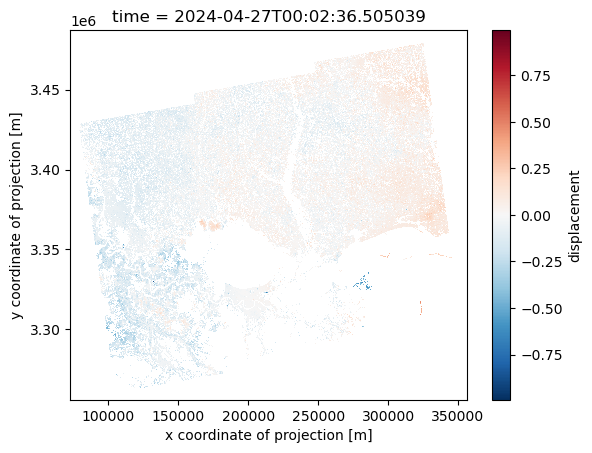

In [13]:
rereference_plot(stack_prod, reference_yx)

Loading data, please wait few seconds


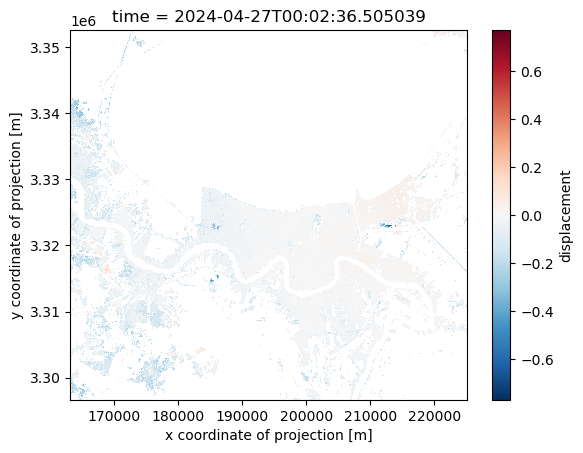

Loading data, please wait few seconds


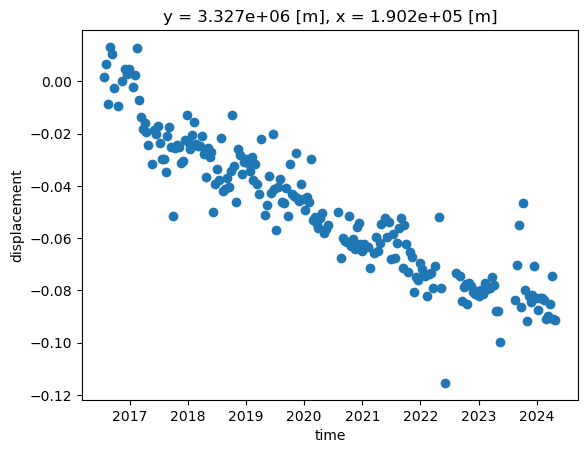

Loading data, please wait few seconds


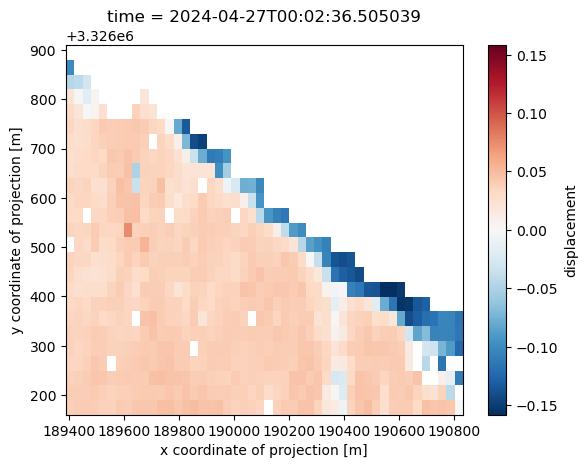

In [14]:
import geopandas as gpd
import shapely.ops
from ipyleaflet import DrawControl, GeoJSON, LayersControl, Map
from ipywidgets import Output, ToggleButton, VBox
from pyproj import CRS, Transformer
from shapely import wkt
from shapely.geometry import Point, Polygon, shape

# Clean GeoDataFrame
gdf = gpd.GeoDataFrame(products_df.copy(), crs=4326)
gdf = gdf.map(lambda x: x.isoformat() if isinstance(x, pd.Timestamp) else x)

# Get center of the geometries
center = gdf.geometry.union_all().centroid
m = Map(center=(center.y, center.x), zoom=6, scroll_wheel_zoom=True)

# Add DISP FRAME bounds
style = {
    'color': 'blue',
    'weight': 1,
    'fillColor': 'transparent',
    'fillOpacity': 0.0
}
hover_style = {
    'color': 'blue',
    'fillOpacity': 0.1
}

geojson_layer = GeoJSON(
    data=gdf.__geo_interface__,
    name="OPERA_DISP",
    style=style,
    hover_style=hover_style
)
m.add_layer(geojson_layer)

# Add Drawing box
draw_out = Output()
draw_control = DrawControl(
    marker={},             # disable marker
    polyline={},           # disable polyline
    polygon={},            # disable polygon
    circlemarker={}        # disable circle marker
)

# Enable rectangle drawing
# Enable only rectangle and circle
draw_control.rectangle = {
    "shapeOptions": {"fillColor": "#6be", "color": "red", "fillOpacity": 0.1, "weight": 2}
}
draw_control.circlemarker = {
    "shapeOptions": {"fillColor": "#f03", "color": "red", "fillOpacity": 0.1, "weight": 2}
}

# Drawn geometry output
@draw_control.on_draw
def handle_draw(target, action, geo_json):
    geom = shape(geo_json['geometry'])
    poly_wkt = geom.wkt
    with draw_out:
        #draw_out.clear_output()
        print("Drawn Geometry WKT:\n", poly_wkt)

    try:
        print("Loading data, please wait few seconds")
        # Load WKT and convert to raster CRS
        aoi = wkt.loads(poly_wkt)
        epsg = pyproj.CRS(stack_prod.spatial_ref.attrs['crs_wkt']).to_epsg()

        # Transform AOI to raster projection
        if isinstance(geom, Point):
            transformer = Transformer.from_crs(4326, CRS.from_epsg(epsg), always_xy=True)
            aoi_utm = shapely.ops.transform(transformer.transform, aoi)
            left, bottom, right, top = aoi_utm.bounds
            rereference_tsplot(stack_prod, reference_yx, (bottom, left))
        elif isinstance(geom, Polygon):
            transformer = Transformer.from_crs(4326, CRS.from_epsg(epsg), always_xy=True)
            aoi_utm = shapely.ops.transform(transformer.transform, aoi)
            left, bottom, right, top = aoi_utm.bounds

            # Subset raster
            stack_subset = stack_prod.sel(y=slice(top, bottom), x=slice(left, right))

            rereference_plot(stack_subset, reference_yx)

    except Exception as e:
        print("Error during raster extraction or plotting:", e)


# Add to map
m.add_control(draw_control)


# Toggle button for enabling/disabling point clicks
click_toggle = ToggleButton(value=False, description='Enable Point Click', button_style='success')

m.add_control(LayersControl(position='topright'))

# Display everything
display(VBox([click_toggle, m, draw_out]))
